In [1]:
!pip install kaggle --upgrade --quiet

import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!kaggle datasets download -d "dansbecker/food-101" -p "/content/drive/MyDrive/KaggleDatasets/food-101"

Dataset URL: https://www.kaggle.com/datasets/dansbecker/food-101
License(s): other
food-101.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip "/content/drive/MyDrive/KaggleDatasets/food-101/food-101.zip"

In [40]:
import random

class Food101Dataset(Dataset):
    def __init__(self, data_dir, split, transform=None, max_images=None):

        self.data_dir = data_dir
        self.img_dir = os.path.join(data_dir, "images")
        self.transform = transform

        #Load the split file(either gonna be train or test)
        split_file = os.path.join(data_dir, f"meta/{split}.txt")
        with open(split_file, "r") as file:
            self.img_paths = file.read().splitlines()

        #Limit dataset (10k instead of 100k)
        if max_images is not None:
            self.img_paths = random.sample(self.img_paths, min(max_images, len(self.img_paths)))

        #Load class names
        class_file = os.path.join(data_dir, "meta/classes.txt")
        with open(class_file, "r") as file:
            self.classes = file.read().splitlines()

        #Map class names to numeric labels
        self.class_to_index = {}
        for index, cls_name in enumerate(self.classes):
            self.class_to_index[cls_name] = index

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        rel_path = self.img_paths[index]
        class_name = os.path.dirname(rel_path)
        label = self.class_to_index[class_name]

        img_path = os.path.join(self.img_dir, rel_path + ".jpg")
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label


In [41]:
# Data augmentations for training
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# For test/validation, only resizing and normalization
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

data_dir = "/content/food-101/food-101"
train_dataset = Food101Dataset(data_dir="/content/food-101/food-101", split="train", transform=train_transforms, max_images=8000)
test_dataset = Food101Dataset(data_dir="/content/food-101/food-101", split="test", transform=test_transforms, max_images=2000)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

num_classes = len(train_dataset.classes)
print("Number of classes:", num_classes)
print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))


Number of classes: 101
Train samples: 8000
Test samples: 2000


In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#load up resnet
model = models.resnet50(pretrained=True)

# freeze base model layers, keeps pre-trained features from imagenet
for param in model.parameters():
    param.requires_grad = False

#replace the final layer for Food101 classes instead of the 1000 in imagenet
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)


Using device: cuda


In [43]:
from tqdm import tqdm  # for the loadingbar

def train_one_epoch(model, loader, criterion, optimizer, epoch, total_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # tqdm progress bar
    progress_bar = tqdm(enumerate(loader), total=len(loader), desc=f"Epoch [{epoch}/{total_epochs}]")

    for batch_index, (images, labels) in progress_bar:
        images, labels = images.to(device), labels.to(device)

        #Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        #Backward pass and optimization
        loss.backward()
        optimizer.step()

        #Save info
        running_loss += loss.item() * images.size(0)
        _, predictions = outputs.max(1)
        correct += prediction.eq(labels).sum().item()
        total += labels.size(0)

        progress_bar.set_postfix({
            "Batch Loss": loss.item(),
            "Running Loss": running_loss / total,
            "Accuracy": 100.0 * correct / total
        })

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct / len(loader.dataset)
    return epoch_loss, epoch_acc

def evaluate(model, loader, criterion):
    model.eval()  # Set model to evaluation mode, consistent behavior
    running_loss =
    correct = 0
    total = 0

    with torch.no_grad():  #No need to track gradients during evaluation
        for images, labels in loader: # go through batches
            images, labels = images.to(device), labels.to(device) # move to right device
            outputs = model(images) # predict current batch
            loss = criterion(outputs, labels) #calc loss

            running_loss += loss.item() * images.size(0)
            _, predictions = outputs.max(1)
            correct += predictions.eq(labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [44]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)
#Metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# training loop
num_epochs = 30
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, epoch, num_epochs)
    val_loss, val_acc = evaluate(model, test_loader, criterion)

    # Append metrics to the lists
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save the best model checkpoint
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_acc': best_acc
        }, "best_model_checkpoint.pth")
        print("Saved best model!")

# Plot the accumulated metrics


Epoch [1/30]: 100%|██████████| 250/250 [00:50<00:00,  4.91it/s, Batch Loss=2.84, Running Loss=3.87, Accuracy=17.1]


Epoch 1/30:
Train Loss: 3.8710, Train Acc: 0.1713
Val Loss: 3.0161, Val Acc: 0.3035


Epoch [2/30]: 100%|██████████| 250/250 [00:48<00:00,  5.12it/s, Batch Loss=2.58, Running Loss=2.77, Accuracy=34.6]


Epoch 2/30:
Train Loss: 2.7678, Train Acc: 0.3463
Val Loss: 2.6903, Val Acc: 0.3545


Epoch [3/30]: 100%|██████████| 250/250 [00:49<00:00,  5.06it/s, Batch Loss=2.46, Running Loss=2.41, Accuracy=42.1]


Epoch 3/30:
Train Loss: 2.4077, Train Acc: 0.4211
Val Loss: 2.5552, Val Acc: 0.3855


Epoch [4/30]: 100%|██████████| 250/250 [00:48<00:00,  5.10it/s, Batch Loss=2.49, Running Loss=2.24, Accuracy=44.8]


Epoch 4/30:
Train Loss: 2.2408, Train Acc: 0.4477
Val Loss: 2.3728, Val Acc: 0.4115


Epoch [5/30]: 100%|██████████| 250/250 [00:48<00:00,  5.12it/s, Batch Loss=2.53, Running Loss=2.14, Accuracy=46.6]


Epoch 5/30:
Train Loss: 2.1418, Train Acc: 0.4664
Val Loss: 2.4290, Val Acc: 0.4165


Epoch [6/30]: 100%|██████████| 250/250 [00:48<00:00,  5.12it/s, Batch Loss=2.01, Running Loss=2.06, Accuracy=48.8]


Epoch 6/30:
Train Loss: 2.0567, Train Acc: 0.4881
Val Loss: 2.4023, Val Acc: 0.4240


Epoch [7/30]: 100%|██████████| 250/250 [00:51<00:00,  4.88it/s, Batch Loss=1.81, Running Loss=1.95, Accuracy=49.8]


Epoch 7/30:
Train Loss: 1.9541, Train Acc: 0.4984
Val Loss: 2.3914, Val Acc: 0.4210


Epoch [8/30]: 100%|██████████| 250/250 [00:50<00:00,  4.95it/s, Batch Loss=2.33, Running Loss=1.91, Accuracy=51.2]


Epoch 8/30:
Train Loss: 1.9112, Train Acc: 0.5122
Val Loss: 2.3442, Val Acc: 0.4360


Epoch [9/30]: 100%|██████████| 250/250 [00:50<00:00,  4.94it/s, Batch Loss=2.03, Running Loss=1.88, Accuracy=52.4]


Epoch 9/30:
Train Loss: 1.8762, Train Acc: 0.5235
Val Loss: 2.3166, Val Acc: 0.4445


Epoch [10/30]: 100%|██████████| 250/250 [00:52<00:00,  4.78it/s, Batch Loss=2.29, Running Loss=1.83, Accuracy=52.7]


Epoch 10/30:
Train Loss: 1.8349, Train Acc: 0.5268
Val Loss: 2.4398, Val Acc: 0.4255


Epoch [11/30]: 100%|██████████| 250/250 [00:49<00:00,  5.04it/s, Batch Loss=2.25, Running Loss=1.78, Accuracy=54]


Epoch 11/30:
Train Loss: 1.7817, Train Acc: 0.5399
Val Loss: 2.4215, Val Acc: 0.4315


Epoch [12/30]: 100%|██████████| 250/250 [00:49<00:00,  5.09it/s, Batch Loss=1.48, Running Loss=1.75, Accuracy=54.5]


Epoch 12/30:
Train Loss: 1.7494, Train Acc: 0.5446
Val Loss: 2.4193, Val Acc: 0.4215


Epoch [13/30]: 100%|██████████| 250/250 [00:51<00:00,  4.86it/s, Batch Loss=1.83, Running Loss=1.7, Accuracy=56]


Epoch 13/30:
Train Loss: 1.7002, Train Acc: 0.5600
Val Loss: 2.3803, Val Acc: 0.4405


Epoch [14/30]: 100%|██████████| 250/250 [00:49<00:00,  5.09it/s, Batch Loss=1.21, Running Loss=1.71, Accuracy=55.4]


Epoch 14/30:
Train Loss: 1.7066, Train Acc: 0.5544
Val Loss: 2.3997, Val Acc: 0.4300


Epoch [15/30]: 100%|██████████| 250/250 [00:49<00:00,  5.03it/s, Batch Loss=1.99, Running Loss=1.65, Accuracy=57]


Epoch 15/30:
Train Loss: 1.6542, Train Acc: 0.5695
Val Loss: 2.3679, Val Acc: 0.4530


Epoch [16/30]: 100%|██████████| 250/250 [00:51<00:00,  4.86it/s, Batch Loss=1.26, Running Loss=1.65, Accuracy=56.8]


Epoch 16/30:
Train Loss: 1.6467, Train Acc: 0.5681
Val Loss: 2.3298, Val Acc: 0.4450


Epoch [17/30]: 100%|██████████| 250/250 [00:49<00:00,  5.01it/s, Batch Loss=1.67, Running Loss=1.6, Accuracy=58.2]


Epoch 17/30:
Train Loss: 1.6022, Train Acc: 0.5819
Val Loss: 2.4476, Val Acc: 0.4340


Epoch [18/30]: 100%|██████████| 250/250 [00:49<00:00,  5.02it/s, Batch Loss=1.95, Running Loss=1.58, Accuracy=58]


Epoch 18/30:
Train Loss: 1.5838, Train Acc: 0.5799
Val Loss: 2.3627, Val Acc: 0.4580


Epoch [19/30]: 100%|██████████| 250/250 [00:51<00:00,  4.82it/s, Batch Loss=1.06, Running Loss=1.59, Accuracy=57.9]


Epoch 19/30:
Train Loss: 1.5884, Train Acc: 0.5794
Val Loss: 2.4646, Val Acc: 0.4370


Epoch [20/30]: 100%|██████████| 250/250 [00:50<00:00,  4.99it/s, Batch Loss=1.66, Running Loss=1.55, Accuracy=58.9]


Epoch 20/30:
Train Loss: 1.5494, Train Acc: 0.5886
Val Loss: 2.3944, Val Acc: 0.4575


Epoch [21/30]: 100%|██████████| 250/250 [00:49<00:00,  5.01it/s, Batch Loss=1.43, Running Loss=1.56, Accuracy=57.8]


Epoch 21/30:
Train Loss: 1.5624, Train Acc: 0.5784
Val Loss: 2.4130, Val Acc: 0.4425


Epoch [22/30]: 100%|██████████| 250/250 [00:52<00:00,  4.80it/s, Batch Loss=1.69, Running Loss=1.5, Accuracy=59.5]


Epoch 22/30:
Train Loss: 1.5039, Train Acc: 0.5945
Val Loss: 2.4562, Val Acc: 0.4395


Epoch [23/30]: 100%|██████████| 250/250 [00:50<00:00,  5.00it/s, Batch Loss=1.15, Running Loss=1.49, Accuracy=59.5]


Epoch 23/30:
Train Loss: 1.4921, Train Acc: 0.5948
Val Loss: 2.4717, Val Acc: 0.4530


Epoch [24/30]: 100%|██████████| 250/250 [00:51<00:00,  4.90it/s, Batch Loss=1.64, Running Loss=1.5, Accuracy=59.9]


Epoch 24/30:
Train Loss: 1.5003, Train Acc: 0.5986
Val Loss: 2.3723, Val Acc: 0.4525


Epoch [25/30]: 100%|██████████| 250/250 [00:52<00:00,  4.78it/s, Batch Loss=1.34, Running Loss=1.49, Accuracy=59.6]


Epoch 25/30:
Train Loss: 1.4898, Train Acc: 0.5964
Val Loss: 2.5419, Val Acc: 0.4355


Epoch [26/30]: 100%|██████████| 250/250 [00:49<00:00,  5.03it/s, Batch Loss=1.38, Running Loss=1.46, Accuracy=60.7]


Epoch 26/30:
Train Loss: 1.4581, Train Acc: 0.6070
Val Loss: 2.5224, Val Acc: 0.4365


Epoch [27/30]: 100%|██████████| 250/250 [00:48<00:00,  5.13it/s, Batch Loss=2.07, Running Loss=1.46, Accuracy=60.4]


Epoch 27/30:
Train Loss: 1.4597, Train Acc: 0.6039
Val Loss: 2.4294, Val Acc: 0.4455


Epoch [28/30]: 100%|██████████| 250/250 [00:50<00:00,  4.91it/s, Batch Loss=0.916, Running Loss=1.45, Accuracy=60.2]


Epoch 28/30:
Train Loss: 1.4548, Train Acc: 0.6019
Val Loss: 2.4622, Val Acc: 0.4495


Epoch [29/30]: 100%|██████████| 250/250 [00:48<00:00,  5.14it/s, Batch Loss=2.07, Running Loss=1.42, Accuracy=61.5]


Epoch 29/30:
Train Loss: 1.4153, Train Acc: 0.6152
Val Loss: 2.4860, Val Acc: 0.4405


Epoch [30/30]: 100%|██████████| 250/250 [00:49<00:00,  5.10it/s, Batch Loss=1.48, Running Loss=1.4, Accuracy=62.1]


Epoch 30/30:
Train Loss: 1.4030, Train Acc: 0.6206
Val Loss: 2.5082, Val Acc: 0.4390


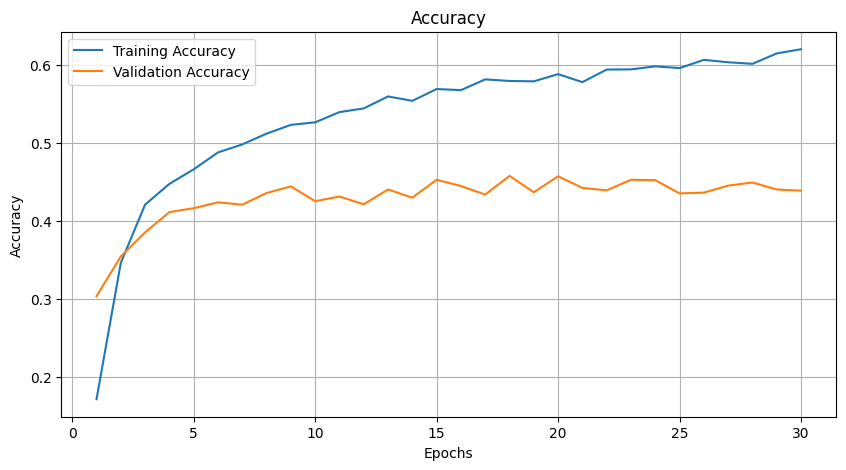

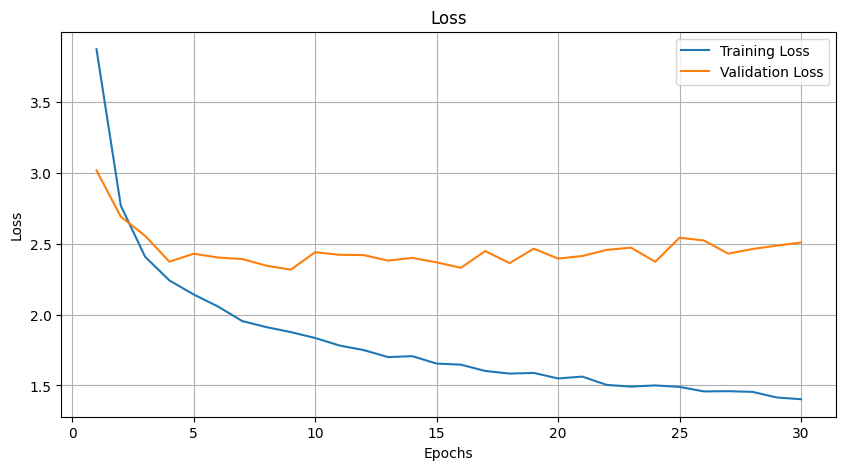

In [45]:
plot_history(train_losses, val_losses, train_accuracies, val_accuracies)


In [47]:
def plot_history(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title("Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title("Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()


Epoch [1/30]: 100%|██████████| 250/250 [00:54<00:00,  4.57it/s, Batch Loss=1.49, Running Loss=1.14, Accuracy=68.1]


Fine-Tune Epoch 1/30
Train Loss: 1.1358, Train Acc: 0.6811
Val Loss: 2.2438, Val Acc: 0.4765


Epoch [2/30]: 100%|██████████| 250/250 [00:49<00:00,  5.10it/s, Batch Loss=1.15, Running Loss=1.09, Accuracy=69.5]


Fine-Tune Epoch 2/30
Train Loss: 1.0943, Train Acc: 0.6949
Val Loss: 2.2856, Val Acc: 0.4750


Epoch [3/30]: 100%|██████████| 250/250 [00:51<00:00,  4.87it/s, Batch Loss=0.901, Running Loss=1.11, Accuracy=68.9]


Fine-Tune Epoch 3/30
Train Loss: 1.1144, Train Acc: 0.6889
Val Loss: 2.2783, Val Acc: 0.4820


Epoch [4/30]: 100%|██████████| 250/250 [00:48<00:00,  5.13it/s, Batch Loss=1.39, Running Loss=1.1, Accuracy=69.2]


Fine-Tune Epoch 4/30
Train Loss: 1.1038, Train Acc: 0.6925
Val Loss: 2.2623, Val Acc: 0.4720


Epoch [5/30]: 100%|██████████| 250/250 [00:49<00:00,  5.09it/s, Batch Loss=0.975, Running Loss=1.1, Accuracy=69.7]


Fine-Tune Epoch 5/30
Train Loss: 1.0984, Train Acc: 0.6967
Val Loss: 2.2431, Val Acc: 0.4800


Epoch [6/30]: 100%|██████████| 250/250 [00:50<00:00,  4.94it/s, Batch Loss=1.01, Running Loss=1.1, Accuracy=69.7]


Fine-Tune Epoch 6/30
Train Loss: 1.0988, Train Acc: 0.6970
Val Loss: 2.2444, Val Acc: 0.4795


Epoch [7/30]: 100%|██████████| 250/250 [00:48<00:00,  5.17it/s, Batch Loss=1.08, Running Loss=1.11, Accuracy=69.5]


Fine-Tune Epoch 7/30
Train Loss: 1.1060, Train Acc: 0.6950
Val Loss: 2.2386, Val Acc: 0.4775


Epoch [8/30]: 100%|██████████| 250/250 [00:49<00:00,  5.10it/s, Batch Loss=0.882, Running Loss=1.08, Accuracy=70.2]


Fine-Tune Epoch 8/30
Train Loss: 1.0824, Train Acc: 0.7021
Val Loss: 2.2532, Val Acc: 0.4765


Epoch [9/30]: 100%|██████████| 250/250 [00:51<00:00,  4.89it/s, Batch Loss=1.18, Running Loss=1.08, Accuracy=70.3]


Fine-Tune Epoch 9/30
Train Loss: 1.0842, Train Acc: 0.7027
Val Loss: 2.2261, Val Acc: 0.4820


Epoch [10/30]: 100%|██████████| 250/250 [00:50<00:00,  4.94it/s, Batch Loss=1.02, Running Loss=1.08, Accuracy=70]


Fine-Tune Epoch 10/30
Train Loss: 1.0832, Train Acc: 0.6997
Val Loss: 2.2684, Val Acc: 0.4830


Epoch [11/30]: 100%|██████████| 250/250 [00:50<00:00,  4.93it/s, Batch Loss=1.04, Running Loss=1.08, Accuracy=71.4]


Fine-Tune Epoch 11/30
Train Loss: 1.0776, Train Acc: 0.7140
Val Loss: 2.2379, Val Acc: 0.4730


Epoch [12/30]: 100%|██████████| 250/250 [00:51<00:00,  4.88it/s, Batch Loss=1.04, Running Loss=1.09, Accuracy=69.9]


Fine-Tune Epoch 12/30
Train Loss: 1.0850, Train Acc: 0.6990
Val Loss: 2.2391, Val Acc: 0.4790


Epoch [13/30]: 100%|██████████| 250/250 [00:49<00:00,  5.04it/s, Batch Loss=0.963, Running Loss=1.08, Accuracy=70.2]


Fine-Tune Epoch 13/30
Train Loss: 1.0845, Train Acc: 0.7020
Val Loss: 2.2404, Val Acc: 0.4720


Epoch [14/30]: 100%|██████████| 250/250 [00:50<00:00,  4.99it/s, Batch Loss=0.943, Running Loss=1.09, Accuracy=70.1]


Fine-Tune Epoch 14/30
Train Loss: 1.0857, Train Acc: 0.7010
Val Loss: 2.2460, Val Acc: 0.4715


Epoch [15/30]: 100%|██████████| 250/250 [00:50<00:00,  4.92it/s, Batch Loss=1.09, Running Loss=1.07, Accuracy=70.1]


Fine-Tune Epoch 15/30
Train Loss: 1.0740, Train Acc: 0.7014
Val Loss: 2.2480, Val Acc: 0.4770


Epoch [16/30]: 100%|██████████| 250/250 [00:50<00:00,  4.95it/s, Batch Loss=1.31, Running Loss=1.07, Accuracy=70]


Fine-Tune Epoch 16/30
Train Loss: 1.0748, Train Acc: 0.7005
Val Loss: 2.2361, Val Acc: 0.4740


Epoch [17/30]: 100%|██████████| 250/250 [00:48<00:00,  5.10it/s, Batch Loss=0.793, Running Loss=1.08, Accuracy=70]


Fine-Tune Epoch 17/30
Train Loss: 1.0841, Train Acc: 0.7000
Val Loss: 2.2474, Val Acc: 0.4745


Epoch [18/30]: 100%|██████████| 250/250 [00:48<00:00,  5.12it/s, Batch Loss=0.971, Running Loss=1.06, Accuracy=70.7]


Fine-Tune Epoch 18/30
Train Loss: 1.0650, Train Acc: 0.7065
Val Loss: 2.2486, Val Acc: 0.4685


Epoch [19/30]: 100%|██████████| 250/250 [00:51<00:00,  4.85it/s, Batch Loss=0.959, Running Loss=1.06, Accuracy=70.6]


Fine-Tune Epoch 19/30
Train Loss: 1.0637, Train Acc: 0.7064
Val Loss: 2.2371, Val Acc: 0.4740


Epoch [20/30]: 100%|██████████| 250/250 [00:49<00:00,  5.03it/s, Batch Loss=1.49, Running Loss=1.06, Accuracy=71]


Fine-Tune Epoch 20/30
Train Loss: 1.0588, Train Acc: 0.7096
Val Loss: 2.2274, Val Acc: 0.4800


Epoch [21/30]: 100%|██████████| 250/250 [00:49<00:00,  5.09it/s, Batch Loss=0.826, Running Loss=1.09, Accuracy=70.3]


Fine-Tune Epoch 21/30
Train Loss: 1.0913, Train Acc: 0.7026
Val Loss: 2.2558, Val Acc: 0.4740


Epoch [22/30]: 100%|██████████| 250/250 [00:51<00:00,  4.88it/s, Batch Loss=0.656, Running Loss=1.05, Accuracy=70.5]


Fine-Tune Epoch 22/30
Train Loss: 1.0526, Train Acc: 0.7050
Val Loss: 2.2339, Val Acc: 0.4765


Epoch [23/30]: 100%|██████████| 250/250 [00:48<00:00,  5.11it/s, Batch Loss=1.31, Running Loss=1.07, Accuracy=70.3]


Fine-Tune Epoch 23/30
Train Loss: 1.0690, Train Acc: 0.7026
Val Loss: 2.2270, Val Acc: 0.4735


Epoch [24/30]: 100%|██████████| 250/250 [00:48<00:00,  5.11it/s, Batch Loss=1.42, Running Loss=1.05, Accuracy=70.7]


Fine-Tune Epoch 24/30
Train Loss: 1.0512, Train Acc: 0.7067
Val Loss: 2.2342, Val Acc: 0.4730


Epoch [25/30]: 100%|██████████| 250/250 [00:51<00:00,  4.89it/s, Batch Loss=1.43, Running Loss=1.06, Accuracy=71.2]


Fine-Tune Epoch 25/30
Train Loss: 1.0590, Train Acc: 0.7125
Val Loss: 2.2205, Val Acc: 0.4800


Epoch [26/30]: 100%|██████████| 250/250 [00:48<00:00,  5.11it/s, Batch Loss=0.811, Running Loss=1.05, Accuracy=71]


Fine-Tune Epoch 26/30
Train Loss: 1.0494, Train Acc: 0.7099
Val Loss: 2.2556, Val Acc: 0.4775


Epoch [27/30]: 100%|██████████| 250/250 [00:48<00:00,  5.13it/s, Batch Loss=1.3, Running Loss=1.06, Accuracy=71.1]


Fine-Tune Epoch 27/30
Train Loss: 1.0584, Train Acc: 0.7113
Val Loss: 2.2498, Val Acc: 0.4750


Epoch [28/30]: 100%|██████████| 250/250 [00:51<00:00,  4.88it/s, Batch Loss=1, Running Loss=1.06, Accuracy=70.8]


Fine-Tune Epoch 28/30
Train Loss: 1.0626, Train Acc: 0.7076
Val Loss: 2.2314, Val Acc: 0.4790


Epoch [29/30]: 100%|██████████| 250/250 [00:48<00:00,  5.11it/s, Batch Loss=1.33, Running Loss=1.04, Accuracy=71]


Fine-Tune Epoch 29/30
Train Loss: 1.0418, Train Acc: 0.7101
Val Loss: 2.2185, Val Acc: 0.4770


Epoch [30/30]: 100%|██████████| 250/250 [00:49<00:00,  5.10it/s, Batch Loss=0.858, Running Loss=1.07, Accuracy=71.1]


Fine-Tune Epoch 30/30
Train Loss: 1.0687, Train Acc: 0.7113
Val Loss: 2.2201, Val Acc: 0.4785


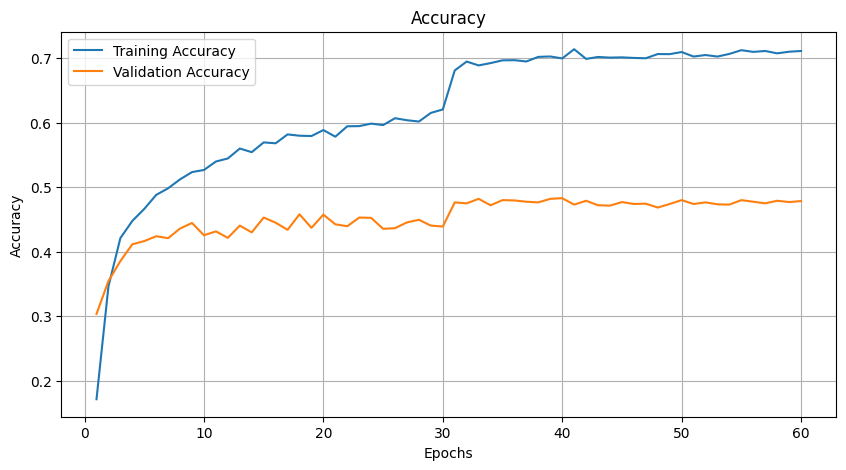

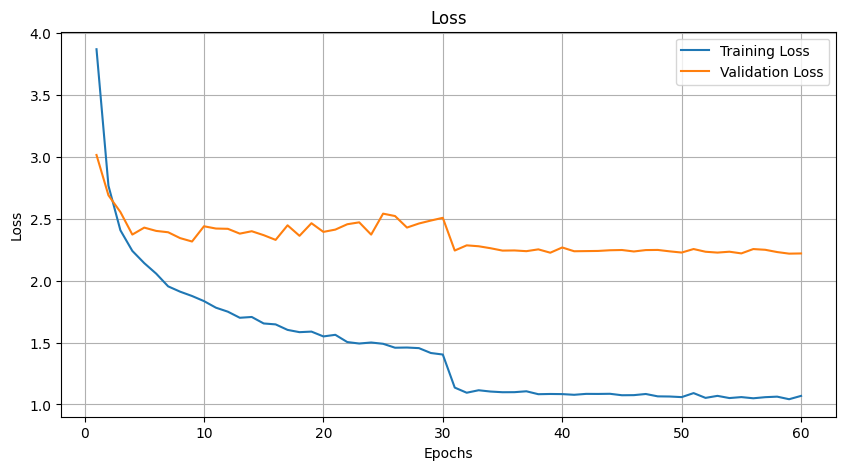

In [48]:
# Unfreeze the last 10 layers in the base model
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last layers (modify based on ResNet structure)
for layer in list(model.children())[-2:]:  # Adjust based on which layers you want to fine-tune
    for param in layer.parameters():
        param.requires_grad = True

# Reinitialize the optimizer for fine-tuning
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

# Fine-tuning loop
fine_tune_epochs = 30
for epoch in range(1, fine_tune_epochs + 1):  # Start from 1 for better logs
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, epoch, fine_tune_epochs)
    val_loss, val_acc = evaluate(model, test_loader, criterion)

    # Append metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Fine-Tune Epoch {epoch}/{fine_tune_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save the best model checkpoint
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_acc': best_acc
        }, "best_model_finetuned.pth")
        print("Saved best finetuned model!")

# Plot the training and validation history
plot_history(train_losses, val_losses, train_accuracies, val_accuracies)


In [50]:
from PIL import Image

def predict_image(image_path, model, classes):
    model.eval()
    img = Image.open(image_path).convert("RGB")

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    img_tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(img_tensor)
        _, predicted = outputs.max(1)
    predicted_class = classes[predicted.item()]
    return predicted_class

# Example usage:
# model.load_state_dict(torch.load("best_model_finetuned.pth"))
# classes = train_dataset.classes
# pred_class = predict_image("/path/to/test_image.jpg", model, classes)
# print("Predicted class:", pred_class)


In [59]:
model.load_state_dict(torch.load("best_model_finetuned.pth"))
classes = train_dataset.classes
pred_class = predict_image("/content/tiramisu.jpg", model, classes)
print("Predicted class:", pred_class)

Predicted class: tiramisu


<ipython-input-59-196c58e41aa6>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_finetuned.pth"))
